In [2]:
import glob
import os
import random

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import segmentation_models_pytorch as smp

from losses import ComboLoss

In [3]:
len(glob.glob('my_data/images/*.png'))

28

In [4]:
img_ids = np.array(glob.glob('my_data/images/*.png'))

In [5]:
train_ids, valid_ids = train_test_split(img_ids, test_size=0.2, random_state=600)

In [6]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(60)
    
torch.backends.cudnn.deterministic = True
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']= '0'
device = 'cuda'

BATCH_SIZE = 16

In [7]:
model = smp.Unet(
    encoder_name='timm-resnest26d',
    encoder_weights='imagenet',
    classes=1,
    activation=None,
).to(device)

criterion = ComboLoss(weights={'bce': 1, 'dice': 1}, channel_weights=[1])
optimizer = torch.optim.Adam(model.parameters(),  lr=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', 
                                                        factor=0.5, patience=4, verbose=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/gluon_resnest26-50eb607c.pth" to C:\Users\iaksh/.cache\torch\hub\checkpoints\gluon_resnest26-50eb607c.pth


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, img_ids, img_dir, transforms):
        self.img_ids = img_ids
        self.img_dir = img_dir
        self.transforms = transforms
        
    def __getitem__(self, item):
        img_path = self.img_ids[item]
        mask_path = self.img_ids[item].replace('images', 'masks')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        
        transformed_data = self.transforms(image=img, mask=mask)
        img = transformed_data['image']
        mask = transformed_data['mask']

        return torch.from_numpy(img).permute(2, 0, 1), torch.from_numpy(mask).unsqueeze(2).permute(2, 0, 1).float(), img_path
    
    def __len__(self):
        return len(self.img_ids)

In [ ]:
train_transforms = A.Compose([
    A.Resize(160, 160),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=1.0),
    A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
    A.Normalize(),
])

test_transforms = A.Compose([
    A.Resize(160, 160),
    A.Normalize(),
])

In [ ]:
train_dataset = SegmentationDataset(train_ids, 'my_data/images/', train_transforms)
valid_dataset = SegmentationDataset(valid_ids, 'my_data/images/', test_transforms)

train_loader = DataLoader(train_dataset, BATCH_SIZE, num_workers=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, BATCH_SIZE, num_workers=4, shuffle=False)

print(len(train_dataset))

In [ ]:
img, mask, img_id = valid_dataset[3]

In [ ]:
plt.imshow(img.permute(1,2,0))

In [ ]:
plt.imshow(mask[0])

In [ ]:
def train_epoch(loader, model, loss_function_seg, optimizer, device):
    model = model.to(device)
    model.train()
    avg_loss = 0.
    optimizer.zero_grad()
    for image, mask, _ in loader:
        x = image.to(device)
        y = mask.to(device)
        prediction_seg = model(x)
        loss = loss_function_seg(prediction_seg, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad() 
        avg_loss += loss.item()
    avg_loss /= len(loader)
    return avg_loss

def valid_epoch(loader, model, device):
    metric = smp.utils.metrics.IoU()
    model.to(device)
    model.eval()
    scores = []
    with torch.no_grad():
        for image, mask, _ in loader:
            x = image.to(device)
            y = mask.to(device)
            probs = torch.sigmoid(model(x))
            scores.append(metric(probs, y).item())
    return sum(scores) / len(scores)

In [ ]:
best_score = 0
best_epoch = 0
for epoch in range(50):
    train_loss = train_epoch(train_loader, model, criterion, optimizer, device)
    valid_score = valid_epoch(valid_loader, model, device, threshold=0.5)
    scheduler.step(valid_score)

    print(train_loss, valid_score)

    if valid_score > best_score:
        best_epoch = epoch
        best_score = valid_score
        torch.save(model.cpu(), f'best_model.pth')
print(best_epoch, best_score)

In [ ]:
model = torch.load("best_model.pth")
model = model.eval()

valid_epoch(valid_loader, model, device)

In [ ]:
img, mask, img_id = valid_dataset[3]

In [ ]:
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))
    pred = torch.sigmoid(pred).squeeze().cpu().numpy()

In [1]:
plt.imshow(img)

NameError: name 'plt' is not defined

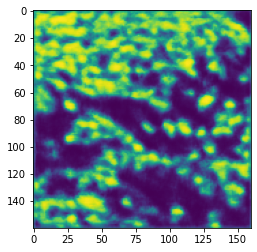

In [380]:
plt.imshow(pred)

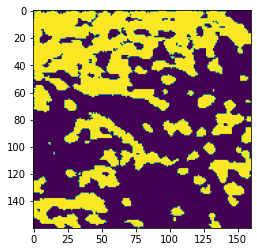

In [381]:
plt.imshow(pred > 0.5)

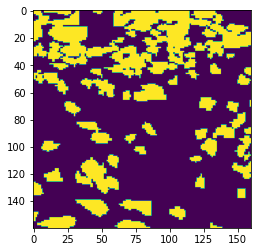

In [383]:
plt.imshow(mask[0])